<a href="https://colab.research.google.com/github/paulaassisb/projeto-final-ds-awari/blob/main/Projeto_Awari_Paula_Assis_(v2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [743]:
## Importação de bibliotecas
import pandas as pd
import numpy as np
import unicodedata
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

##1. Importação da base de dados

In [744]:
## Importando arquivo da coleta de dados
url = 'https://raw.githubusercontent.com/paulaassisb/projeto-final-ds-awari/main/coleta_dados_quest_projeto_final.csv'

In [745]:
dados_quest = pd.read_csv(url)

In [746]:
## Transformando em DataFrame para visualização e manipulação dos dados
df = pd.DataFrame(dados_quest)

In [747]:
df.head()

,Numero do Sujeito,1a. Doença,Idade 1a. Doença,Tempo 1a Doença,Sexo,UF Nascimento,UF,Formação,Atividade,Escolaridade,Estado Civil,Religião,Outro Idioma,Análise do Contexto,Autoconfiança,Autocontrole,Conquistar e Manter Pessoas,Empatia,Leitura Corporal,Otimismo com a Vida,Sentido da Vida
0,13531,depressão,31 - 49 anos,Um ano,Feminino,SP,SP,Administradora,Gerente de Compras,Pós-Graduação,Casado,Católico,Sim,Boa no estresse (PC-P),Fraca no estresse (PC-I),Fraca no estresse (PC-I),Boa diante do impacto do estresse (PC-P),Moderada no estresse (PC-I),Excelente no estresse,Forte no estresse (PC-P),Boa no estresse (PC-P)
1,13532,enfermidade que me levou a 15 dias de hospital...,7 - 12 anos,Mais de um ano,Masculino,SP,SP,Arquiteto,NaN,Pós-Graduação,Casado,Evangélico,Sim,Excelente no estresse,Moderada no estresse (PC-I),Fraca no estresse (PC-I),Boa diante do impacto do estresse (PC-P),Boa no estresse (PC-P),Boa no estresse (PC-P),Excelente no estresse,Moderada no estresse (PC-P)
2,13533,Violência dentro de casa,7 - 12 anos,Mais de um ano,Masculino,SP,SP,NaN,Pesquisa e leitura de livros,Superior Completo,Solteiro,Outro,Não,Boa no estresse (PC-P),Forte no estresse (PC-P),Moderada no estresse (PC-P),Boa diante do impacto do estresse (PC-P),Boa no estresse (PC-P),Moderada no estresse (PC-P),Excelente no estresse,Boa no estresse (PC-P)
3,13534,NaN,NaN,NaN,Masculino,SP,SP,Administração de Empresas,Analista de Mercado,Superior Completo,Solteiro,Evangélico,Sim,Excelente no estresse,Fraca no estresse (PC-I),Fraca no estresse (PC-I),Forte diante do impacto do estresse (PC-P),Excelente no estresse,Boa no estresse (PC-P),Boa no estresse (PC-P),Boa no estresse (PC-P)
4,13535,Conhecer a comunidade quilombola Pedro Cubas,13 - 17 anos,Mais de um ano,Masculino,SP,SP,NaN,NaN,Superior Incompleto,Solteiro,Evangélico,Sim,Excelente no estresse,Excelente face ao estresse,Excelente no estresse,Excelente face ao impacto do estresse (PC-E),Forte no estresse (PC-P),Boa no estresse (PC-P),Excelente no estresse,Excelente no estresse


##2. Preparação dos dados


**Transformando as colunas**

In [748]:
## Nomes das colunas (todos em minúsculo e sem espaço)
df.columns.str.lower()
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [749]:
## Renomear colunas relacionadas a doença/trauma
df = df.rename(columns={'1a._doença': 'trauma_doenca', 'idade_1a._doença': 'idade_trauma', 'tempo_1a_doença': 'tempo_trauma', 
                        'formação': 'formacao', 'religião': 'religiao', 'análise_do_contexto': 'analise_contexto', 'autoconfiança': 'autoconfianca',
                        'conquistar_e_manter_pessoas': 'conquistar', 'otimismo_com_a_vida': 'otimismo'})

In [750]:
#Removendo colunas não necessárias
df = df.drop(columns=['numero_do_sujeito', 'atividade', 'uf_nascimento', 'uf', 'outro_idioma'])

**Tratamento de valores nulos (NaN)**

In [751]:
df = df.dropna(subset=['trauma_doenca', 'idade_trauma', 'tempo_trauma'])

**Transformando objetos em categorias**

In [752]:
#Transformando objetos em strings
# label_encoder = LabelEncoder() - não funcionou como esperado, porque classifica por ordem alfabética

escolaridade = {'1ª a 4ª série': 0, '5ª a 9ª série': 1, 'Ensino Médio': 2, 'Técnico': 3, 'Superior Completo': 4, 'Superior Incompleto': 5, 'Pós-Graduação': 6}
df ['escolaridade'] = df.escolaridade.map (escolaridade)



In [753]:
for feature in df.columns:
    print('The feature is {} and number of categories are {}'.format(feature,len(df[feature].unique())))

The feature is trauma_doenca and number of categories are 1722
The feature is idade_trauma and number of categories are 6
The feature is tempo_trauma and number of categories are 5
The feature is sexo and number of categories are 2
The feature is formacao and number of categories are 721
The feature is escolaridade and number of categories are 7
The feature is estado_civil and number of categories are 5
The feature is religiao and number of categories are 4
The feature is analise_contexto and number of categories are 20
The feature is autoconfianca and number of categories are 22
The feature is autocontrole and number of categories are 24
The feature is conquistar and number of categories are 22
The feature is empatia and number of categories are 23
The feature is leitura_corporal and number of categories are 24
The feature is otimismo and number of categories are 23
The feature is sentido_da_vida and number of categories are 23


In [754]:
#Aplicando a moda em valores nulos nas colunas Idade e Tempo de duração da doença ou trauma
df['tempo_trauma']=df['tempo_trauma'].fillna(df['tempo_trauma'].mode()[0])
df['idade_trauma']=df['idade_trauma'].fillna(df['idade_trauma'].mode()[0])

**Padronização do dataframe**


In [755]:
#Padronizando dataframe em minúsculo e sem acentuação

for column in df.columns:
  df[column] = df[column].astype(str).str.lower()
  
cols = df.select_dtypes(include=[np.object]).columns
df[cols] = df[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

**Padronizando coluna "Trauma ou Doença"**

In [756]:
stopwords = ['a', 'minha', 'que', 'me', 'de', 'e', 'na', 'quase', 'dos', 'do', 'meus', 'da', 'aos', 'um', 'numa', 'teve', 'enquanto', 'meu', 
             'sem', 'no', 'para', 'primeira', 'com', 'muito', 'fui', 'durante', 'uma', 'em', 'por', 'o', 'quando', 'eu', 'tive']

In [757]:
def removestopword (texto):
  semstop = [p for p in texto.split() if p not in stopwords]
  return ' '.join(semstop)

In [758]:
df['trauma_doenca'] = df['trauma_doenca'].apply(removestopword)

In [759]:
CATEGORIAS = {'saude_doenca': ['enfermidade', 'pneumonia', 'tumor', 'labirintite', 'corte', 'cirurgia', 
              'vesicula', 'queimadura', 'fratura', 'chron', 'hernia', 'hepatite', 'disco', 'bronquite', 'apendicite', 'caxumba', 'tireoide',
              'hipertensao', 'torci', 'artrodese', 'gordura', 'lesao', 'sarampo', 'narcolepsia', 'tenorrafia', 'disfuncao', 'condropatia',
              'asma', 'dor', 'gastrite', 'internacao', 'infarto', 'febre', 'meningite', 'obesidade', 'alzhimer', 'anemia', 'neurolofica',
              'neurologico', 'doenca', 'avc', 'visicula', 'ernia', 'cardiaco', 'edema', 'presao', 'tibia', 'renal', 'operacao', 'braco', 'adoecimento',
              'basite', 'lombares', 'dengue', 'coluna', 'menigite', 'audicao', 'infeccao', 'pericardite', 'catarata', ' inflamacao',
              'operei', 'convulsao', 'abcesso', 'artrite', 'trombose', 'catapora', 'infarte', 'epilepsia', 'torcao', 'deslocar', 'inflamacao', 'renais',
              'quebrei', 'tireoide', 'micose', 'clavicula', 'fraturei', 'diabete', 'prielonefrite', 'rcp', 'cisto', 'amputacao', 'toxoplasmose',
              'comvulcao', 'hemorragia', 'derbuculoce', 'deboculose', 'operasao', 'viral', 'virus', 'internado', 'toc', 'traumatismo', 'alergia',
              'enxaqueca', 'apendice', 'verme', 'visual', 'pylori', 'cardiaca', 'garganta', 'cicatriz', 'sifiles', 'bacteria',
              'gagueira', 'salmonela', 'eclampsia', 'retina', 'gripe', 'taquicardia', 'ictiose', 'entalado', 'endometriose', 'denque', 'quebraduras', 
              'quebrado', 'osso', 'quebrar', 'joelho', 'tornozelo', 'cancer', 'hiv', 'tuberculose',  'cardiopatia', 'esclerose',
              'falecimento', 'morte', 'falaceu', 'ente', 'perdas', 'perda', 'obito', 'perca', 'perde', 'falecido', 
              'ansiedade', 'depressao', 'panico', 'estresse', 'traumatico', 'suicidio', 'disturbio', 'perdi', 'mutilacoes',
              'sociais', 'rejeicao', 'burnout', 'bulimia', 'alcool', 'bebida', 'alcolismo', 'alcoolismo', 'drogas', 'vicio', 'pedofilia'],

              'relacoes_interpessoais': ['separacao', 'divorcio', 'separaram', 'conjugal', 'relacionamento', 'traicao', 'gravidez', 'aborto', 'feto',
                                         'estupro', 'abuso', 'abusado', 'interpessoais', 'namoro', 'violencia', 'VIOLÊNCIA', 'violência', 'sequestro', 
                                         'arma', 'baleado', 'assassinato', 'agressor','assalto', 'assaltada'],
              
              'desempenho': ['trabalho', 'escola', 'vestibular', 'desemprego', 'desligado', 'acidente', 'acicente', 'queda', 'capotamento', 
                             'atrolepamento', 'batida', 'atropelamento', 'afogamento', 'carro', 'moto', 'atropelado', 'financeiras'],

              'outros': [ 'preso', 'nenhuma resposta', 'nenhuma', 'nenhum', 'nao houve', '2010', 'nao considero', 'nada', 
                         'nao ha', 'nao recordo', 'ca', 'i', 'nao', '']}

In [760]:
CATEGORIAS.keys()

dict_keys(['saude_doenca', 'relacoes_interpessoais', 'desempenho', 'outros'])

In [761]:
def procurar_palavra(lista_palavras, sentenca):
  palavra_presente=False
  for palavra in lista_palavras:
    if palavra in sentenca:
      palavra_presente=True
  return palavra_presente

def mapear_categoria(sentenca):
  for cat in CATEGORIAS.keys():
    if procurar_palavra(CATEGORIAS[cat], sentenca):
      return cat 
  return sentenca

In [762]:
sentenca = 'violencia dentro casa'
mapear_categoria(sentenca)

'relacoes_interpessoais'

In [763]:
df['trauma_doenca'] = df['trauma_doenca'].apply(mapear_categoria)

**Padronizando coluna "Formação"**

In [764]:
df['formacao'] = df['formacao'].apply(removestopword)

In [765]:
CAT_FORMACAO = {'ciencias exatas': ['contador', 'contadora', 'contabeis', 'economicas', 'contabil', 'contabilista', 'quimica', 'quimico', 'fisico', 'fisica',
                                    'engenharia', 'engenheiro', 'engenheira', 'eng', 'economia', 'financas', 'economista', 'estatistico',
                                    'ti', 'informatica', 'computacao', 'redes', 'sistemas', 'informacao', 'dados', 'sistema', 'desenvolvedor', 'programador',
                                    'arquiteto', 'arquiteta', 'arquitetura'],
                
                'ciencias humanas': ['historia', 'geografo', 'geografia', 'filosofia', 'filosofo', 'filosofa', 'sociologo', 'filosifia',
                                     'militar', 'molitar', 'bombeito', 'bombeiro', 'bombeira', 'bombeiros', 'oficial', 'defesa civil', 
                                     'bm', 'seguranca', 'cbmdf', 'administradora', 'administracao', 'administrador', 'adm', 'rh', 'empresarial', 
                                     'empresaria', 'aministracao', 'secretaria', 'empresario', 'escritorio', 'negocios', 'secretariado', 'recursos humanos',
                                     'internacionais', 'gestao', 'exterior', 'gestora', 'propaganga', 'marketing', 'relacoes publicas', 'comunicacao', 
                                     'grafica', 'artes', 'designer', 'publicitario', 'publicitaria', 'fotografo', 'comunicadora', 'jornalismo', 
                                     'telecomunicacoes', 'radiologia', 'jornalista', 'imprensa', 'artes', 'design', 'publicidade',
                                     'professor', 'professora', 'pedagogia', 'letras', 'pedagogo', 'pedagoga', 'pedagogica', 'pedadogia', 'pedagogica',
                                     'psicologa', 'psicologo', 'psicologia', 'psicanalista', 'terapia', 'psicolgia', 'advoga', 'advocacia', 'direito', 
                                     'advogada', 'advogado'],


                'ciencias biologicas': ['medico', 'medica', 'medicina', 'enfermeiro', 'enfermeira', 'enfermagem', 'nutricionista', 'nutricao', 'neurocirurgiao',
                'farmaceutica', 'clinica', 'biomedicina', 'cirurgia', 'optometria', 'odontologia', 'odontologia'],

                'outras areas': ['comercial', 'compradora', 'contas', 'testador quest', 'metalurgico', 'ambiental', 'pos',
                'grau', 'escultor', 'turimologa', 'turismologo', 'oceanografa', 'assistente', 'superior', 'seminarista', 'agro',
                'elitricista', 'logistica', 'gastronomia', 'aprendiz', 'mallet', 'operacoes', 'vendas', 'musico', 'coml', 'podologa',
                'manicure', 'corretora', 'bancario', 'gerente', 'massoterapeuta', 'biologo', 'biologia', 'turismo', 'arte', 'mecanico',
                'mecanica', 'fisioterapeuta', 'juridica', 'educador fisico', 'educacao fisica', 'operadora', 'vendedora', 'eletronica',
                'cfo', 'teologia', 'funcionario', 'qualidade', 'teologo', 'condutor.', 'pianista', 'funcionaria', 'nao', 'n', 'nenhuma', 'nenhum',
                'barista', 'biologa', 'cabeleireiro', 'cabelereira', 'coach',  'comprador', 'corretor', 'costureira', 'moda', 'decoradora',
                'doutorado', 'fisiva', 'estagiario', 'farmacia', 'filosifia', 'graduacao', 'graducao', 'hotelaria', 'lavrador', 'maestro', 'magisterio',
                'mba', 'mercadologa', 'mestrado', 'moda', 'motorista', 'musica', 'musicista', 'radialista', 'servidor', 'social', 'taxista', 'tradutora',
                'soldador', 'sim', 'sueprior', 'solteira', '****', 'estudante', 'estudanta', 'estudanti', 'estudar', 'escola', 'mastologista', 'bacharel']}

In [766]:
CAT_FORMACAO.keys()

dict_keys(['ciencias exatas', 'ciencias humanas', 'ciencias biologicas', 'outras areas'])

In [767]:
def procurar_palavra_form(lista_palavras_form, sentenca_form):
  palavra_presente_form=False
  for palavra_form in lista_palavras_form:
    if palavra_form in sentenca_form:
      palavra_presente_form=True
  return palavra_presente_form

def mapear_categoria2(sentenca_form):
  for categ in CAT_FORMACAO.keys():
    if procurar_palavra_form(CAT_FORMACAO[categ], sentenca_form):
      return categ
  return sentenca_form

In [768]:
sentenca_form = 'administradora'
mapear_categoria2(sentenca_form)

'ciencias humanas'

In [769]:
df['formacao'] = df['formacao'].apply(mapear_categoria2)

###Padronização das áreas da vida

In [770]:
AREAS_DA_VIDA = {'boa_pcp': ['boa no estresse (pc-p)', 'boa face ao estresse (pc-p)', 'boa diante do impacto do estresse (pc-p)'],
      'boa_pci': ['boa no estresse (pc-i)', 'boa face ao estresse (pc-i)', 'boa diante do impacto do estresse (pc-i)', 'boa face ao impacto do estresse (pc-i)'],
      'equilibrio': ['excelaancia face ao estresse', 'excelente face ao estresse', 'excelente no estresse', 'excelente face ao impacto do estresse (pc-e)'],
      'forte_pci': ['forte face ao estresse (pc-i)', 'forte diante do estresse (pc-i)', 'forte no estresse (pc-i)', 'forte face ao estresse (pc- i)', 'forte diante do impacto do estresse (pc-i)'],
      'forte_pcp': ['forte no estresse (pc-p)', 'forte face ao estresse (pc-p)', 'forte diante do estresse (pc-p)', 'forte diante do impacto do estresse (pc-p)'],
      'fraca_pci': ['fraca no estresse (pc-i)', 'fraca face ao estresse (pc-i)', 'fraca diante do estresse (pc-i)', 'fraca diante do impacto do estresse (pc-i) '],
      'fraca_pcp': ['fraca no estresse (pc-p)', 'fraca face ao estresse (pc-p)', 'fraca diante do impacto do estresse (pc-i)'],
      'moderada_pcp': ['moderada no estresse (pc-p)', 'moderada perante o estresse (pc-p)', 'moderada face ao estresse (pc-p)', 'moderada diante do impacto do estresse (pc-p)'],
      'moderada_pci': ['moderada no estresse (pc-i)', 'moderada perante o estresse (pc-i)', 'moderada face ao estresse (pc-i)', 'moderada diante do impacto do estresse (pc-i)']}

In [771]:
AREAS_DA_VIDA.keys()

dict_keys(['boa_pcp', 'boa_pci', 'equilibrio', 'forte_pci', 'forte_pcp', 'fraca_pci', 'fraca_pcp', 'moderada_pcp', 'moderada_pci'])

In [772]:
def procurar_palavra_sv(lista_palavras_sv, sentenca_sv):
  palavra_presente_sv=False
  for palavra_sv in lista_palavras_sv:
    if palavra_sv in sentenca_sv:
      palavra_presente_sv=True
  return palavra_presente_sv

def mapear_categoria_sv(sentenca_sv):
  for categ_sv in AREAS_DA_VIDA.keys():
    if procurar_palavra_sv(AREAS_DA_VIDA[categ_sv], sentenca_sv):
      return categ_sv
  return sentenca_sv

In [773]:
sentenca_sv = 'excelente no estresse'
mapear_categoria_sv(sentenca_sv)

'equilibrio'

In [774]:
df['analise_contexto'] = df['analise_contexto'].apply(mapear_categoria_sv)
df['conquistar'] = df['conquistar'].apply(mapear_categoria_sv)
df['autoconfianca'] = df['autoconfianca'].apply(mapear_categoria_sv)
df['autocontrole'] = df['autocontrole'].apply(mapear_categoria_sv)
df['empatia'] = df['empatia'].apply(mapear_categoria_sv)
df['leitura_corporal'] = df['leitura_corporal'].apply(mapear_categoria_sv)
df['otimismo'] = df['otimismo'].apply(mapear_categoria_sv)
df['sentido_da_vida'] = df['sentido_da_vida'].apply(mapear_categoria_sv)

In [775]:
## Transformando em binário as categorias
df["analise_contexto"] = df["analise_contexto"].apply(lambda x: 0 if any(item in x for item in ['fraca', 'moderada']) else 1)
df["autoconfianca"] = df["autoconfianca"].apply(lambda x: 0 if any(item in x for item in ['fraca', 'moderada']) else 1)
df["autocontrole"] = df["autocontrole"].apply(lambda x: 0 if any(item in x for item in ['fraca', 'moderada']) else 1)
df["conquistar"] = df["conquistar"].apply(lambda x: 0 if any(item in x for item in ['fraca', 'moderada']) else 1)
df["empatia"] = df["empatia"].apply(lambda x: 0 if any(item in x for item in ['fraca', 'moderada']) else 1)
df["leitura_corporal"] = df["leitura_corporal"].apply(lambda x: 0 if any(item in x for item in ['fraca', 'moderada']) else 1)
df["otimismo"] = df["otimismo"].apply(lambda x: 0 if any(item in x for item in ['fraca', 'moderada']) else 1)
df["sentido_da_vida"] = df["sentido_da_vida"].apply(lambda x: 0 if any(item in x for item in ['fraca', 'moderada']) else 1)

In [776]:
lb_enc = LabelEncoder()
df['religiao'] = lb_enc.fit_transform(df[["religiao"]])
df['formacao'] = lb_enc.fit_transform(df[["formacao"]])
df['estado_civil'] = lb_enc.fit_transform(df[["estado_civil"]])
df['idade_trauma'] = lb_enc.fit_transform(df[["idade_trauma"]])
df['tempo_trauma'] = lb_enc.fit_transform(df[["tempo_trauma"]])
df['escolaridade'] = lb_enc.fit_transform(df[["escolaridade"]])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [777]:
df = pd.get_dummies(df, columns=['sexo'])

In [778]:
df.head()

,trauma_doenca,idade_trauma,tempo_trauma,formacao,escolaridade,estado_civil,religiao,analise_contexto,autoconfianca,autocontrole,conquistar,empatia,leitura_corporal,otimismo,sentido_da_vida,sexo_feminino,sexo_masculino
0,saude_doenca,2,4,2,6,0,0,1,0,0,1,0,1,1,1,1,0
1,saude_doenca,3,1,1,6,0,2,1,0,0,1,1,1,1,0,0,1
2,relacoes_interpessoais,3,1,3,4,2,3,1,1,0,1,1,0,1,1,0,1
4,outros,0,1,3,5,2,2,1,1,1,1,1,1,1,1,0,1
5,saude_doenca,0,1,1,4,2,0,1,1,1,1,1,1,0,1,1,0


In [779]:
df = df.drop(columns=['formacao', 'estado_civil', 'escolaridade', 'religiao', 'sexo_feminino', 'sexo_masculino', 'idade_trauma', 'tempo_trauma'])

##3. Modelagem dos dados

In [780]:
# Separar Dados de Entrada (Atributos) e de saída (target)
X = df.drop('trauma_doenca', axis=1)
y = df.trauma_doenca

In [781]:
X.head()

,analise_contexto,autoconfianca,autocontrole,conquistar,empatia,leitura_corporal,otimismo,sentido_da_vida
0,1,0,0,1,0,1,1,1
1,1,0,0,1,1,1,1,0
2,1,1,0,1,1,0,1,1
4,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,0,1


In [782]:
y.head()

0              saude_doenca
1              saude_doenca
2    relacoes_interpessoais
4                    outros
5              saude_doenca
Name: trauma_doenca, dtype: object

**Divisão da base entre teste e treino**

In [783]:
## Importando biblioteca para fazer a divisão da base entre teste/treino
## Boa prática - Não usar o random_state
## Verificar antes se precisa do stratify (quando a base não está balanceada)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2)

In [784]:
#Benchmark
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

y_pred = dummy_clf.predict(X_test)

In [785]:
# Acuracia
np.mean(y_pred==y_test) *100

68.646080760095

Text(33.0, 0.5, 'Real ( 1 ou 0)')

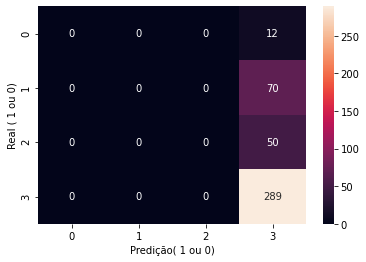

In [786]:
#Matriz de confusão
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predição( 1 ou 0)')
plt.ylabel('Real ( 1 ou 0)')

In [787]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                        precision    recall  f1-score   support

            desempenho       0.00      0.00      0.00        12
                outros       0.00      0.00      0.00        70
relacoes_interpessoais       0.00      0.00      0.00        50
          saude_doenca       0.69      1.00      0.81       289

              accuracy                           0.69       421
             macro avg       0.17      0.25      0.20       421
          weighted avg       0.47      0.69      0.56       421



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Machine Learning

Treinando e Avaliando no Conjunto de Treino

In [788]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [789]:
# Acuracia
lr.score(X_test, y_test)*100

68.646080760095

In [790]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)*100

68.646080760095

In [791]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [792]:
lista_classificacores = [DecisionTreeClassifier(),
                         RandomForestClassifier(),
                         XGBClassifier()]

for clf in lista_classificacores:
  print(clf.__class__.__name__)
  clf.fit(X_train, y_train)

  print('Acuracia')
  train_acc=clf.score(X_train, y_train)
  test_acc=clf.score(X_test, y_test)
  print('Treino:', train_acc)
  print('Teste:', test_acc)

  print('ROC AUC')
  y_proba_train = clf.predict_proba(X_train)
  roc_train=roc_auc_score(y_train, y_proba_train, multi_class='ovo')
  print('Treino', roc_train)

  y_proba_test = clf.predict_proba(X_test)
  roc_test = roc_auc_score(y_test, y_proba_test, multi_class='ovo')
  print('Test', roc_test)
  print('='*80)

DecisionTreeClassifier
Acuracia
Treino: 0.7051129607609988
Teste: 0.6603325415676959
ROC AUC
Treino 0.7408791471332066
Test 0.5703073405832921
RandomForestClassifier
Acuracia
Treino: 0.7051129607609988
Teste: 0.6745843230403801
ROC AUC
Treino 0.7398563129738701
Test 0.5568300996869336
XGBClassifier
Acuracia
Treino: 0.6902497027348394
Teste: 0.684085510688836
ROC AUC
Treino 0.647603302201832
Test 0.5441547207118141


In [793]:
clf=XGBClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

Text(33.0, 0.5, 'Real ( 1 ou 0)')

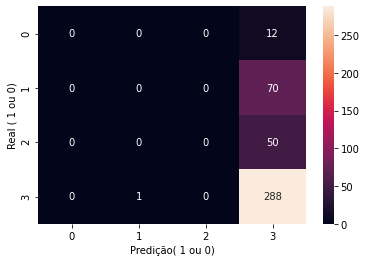

In [794]:
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predição( 1 ou 0)')
plt.ylabel('Real ( 1 ou 0)')

ROC AUC de Teste é DecisionTreeClassifier é 54.54%


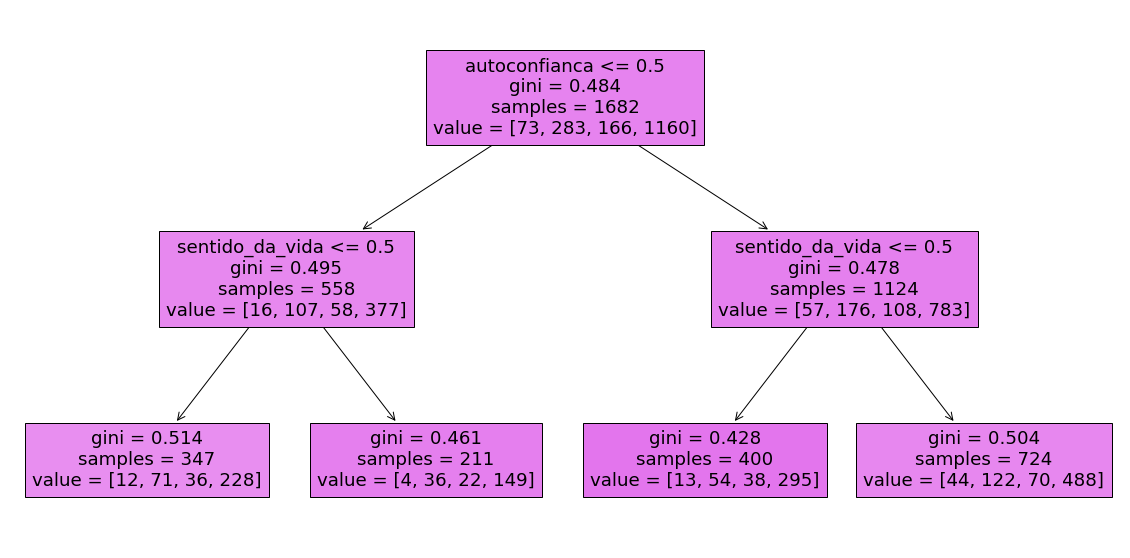

In [795]:
# Visualizar Árvore de Decisão com baixa profundidade
from sklearn.tree import plot_tree
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X_train, y_train) 
y_proba = clf.predict_proba(X_test)
roc_auc=roc_auc_score(y_test, y_proba, multi_class='ovo')

print(f'ROC AUC de Teste é {clf.__class__.__name__} é {roc_auc*100:.2f}%')

plt.figure(figsize=(20,10))
annotations = plot_tree(clf,
                        feature_names=X_train.columns,
                        filled=True)